# Plotting Convex Hulls

## Plot some random points

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint
from scipy.spatial import ConvexHull
import folium
import simplekml
import numpy as np

df = pd.DataFrame({"id": ['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 
                          'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'],
                   'lat': [34.5510978, 34.5514266, 34.5516808, 34.5512608, 34.5518526, 34.5515426, 34.55157826, 34.55144526,
                           34.5534, 34.55335, 34.5528, 34.554, 34.5530, 34.5534, 34.55354, 34.55323],
                   'lon': [69.1879857, 69.1869932, 69.1878399, 69.1868499, 69.187510, 69.187507, 69.187607, 69.187357,
                           69.1835, 69.1833, 69.18375, 69.1832, 69.1835, 69.1838, 69.1839, 69.1835]})

# plot the map tracks
url_base = 'https://server.arcgisonline.com/ArcGIS/rest/services/'
service = 'World_Street_Map/MapServer'
attribution = 'ESRI'
tileset = url_base + service
map_center = [df.lat.mean(), df.lon.mean()]
m = folium.Map(location=(map_center[0], map_center[1]), zoom_start = 17)
for i in range(0,len(df)):
    folium.CircleMarker([df.iloc[i]['lat'], df.iloc[i]['lon']], 
                        color = df.iloc[i]['id'], radius = 2).add_to(m)
m

## Identify the convex hull for one set of points and convert to a geometry object

1. Plot the point geometry


2. Identify the outer most points that make up the convex hull and plot the points


3. Convert the multi-point geometry to a polygon


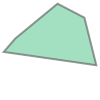

In [2]:
# Cast the lat/lon columns of the point data frame to an array of coordinate tuples
red_pts = df[df['id'] == 'red']
coords = np.array(red_pts[['lon', 'lat']])

print("1. Plot the point geometry")
display(MultiPoint(coords))

print("2. Identify the outer most points that make up the convex hull and plot the points")
hull_pts = ConvexHull(coords)
display(MultiPoint(coords[hull_pts.vertices,:].tolist()))

print("3. Convert the multi-point geometry to a polygon")
convex_hull = MultiPoint(coords[hull_pts.vertices,:].tolist()).convex_hull
display(convex_hull)

## Repeat the convex hull processing for the complete data frame

In [3]:
ids = df['id'].unique().tolist()
convex_hull_dfs = []
for value in ids:
    sub_df = df[df['id']==value]
    coords = np.array(sub_df[['lon', 'lat']])
    hull_pts = ConvexHull(coords)
    convex_hull = MultiPoint(coords[hull_pts.vertices,:].tolist()).convex_hull
    convex_hull_dfs.append(pd.DataFrame({'id': [value], 'geometry': convex_hull}))

convex_hull_dfs = pd.concat(convex_hull_dfs).reset_index(drop = True)
convex_hull_dfs.head()

id                                           geometry
0   red  POLYGON ((69.1879857 34.5510978, 69.1868499 34...
1  blue  POLYGON ((69.18375 34.5528, 69.1835 34.553, 69...

## Plot the convex hulls on the folium map

In [4]:
plotjson = gpd.GeoDataFrame(convex_hull_dfs, crs="EPSG:4326")
plotjson = plotjson.to_json()
folium.GeoJson(plotjson).add_to(m)
m

## Write hulls to a kmz file

In [5]:
polygon_labels = convex_hull_dfs.id

kml = simplekml.Kml()
for i in range(0, len(polygon_labels)):
    pol = kml.newpolygon(name=polygon_labels[i])
    pol.outerboundaryis = list(convex_hull_dfs['geometry'][i].exterior.coords)
    pol.style.linestyle.color = simplekml.Color.blue
    pol.style.linestyle.width = 5
    pol.style.polystyle.color = simplekml.Color.changealphaint(100, simplekml.Color.green)

kml.save("convex_hulls.kml")